# 🧑‍🎨 Fancy Runhouse - Dreambooth in <10 Minutes

This tutorial shows how you can easily import and reuse GitHub code using Runhouse. In just a few lines of code, we can fine-tune Stable Diffusion using Dreambooth and perform inference.

Note that this code runs on **your own GPU**. You can run this on your own cluster, or through a standard cloud account (AWS, GCP, Azure, LambdaLabs). If you do not have any compute or cloud accounts set up, we recommend creating a [LambdaLabs](https://cloud.lambdalabs.com/) account for the easiest setup path.

### Install Runhouse

In [ ]:
!pip install runhouse

In [ ]:
import runhouse as rh

### [Optional] Log in to Runhouse to load in secrets.

In [ ]:
# You can add token=<your token> if you want to be able to run this without pasting into stdin
rh.login(download_secrets=True, download_config=True, interactive=True)

In [ ]:
# Only if you're using GCP and running inside Colab!
!gcloud init
!gcloud auth application-default login
!cp -r /content/.config/* ~/.config/gcloud

In [ ]:
# Check that secrets are loaded in properly and at least one cloud is ready to use.
!sky check

## Dreambooth Fine-Tuning and Inference

Please refer to [cluster setup](https://runhouse-docs.readthedocs-hosted.com/en/main/installation.html#cluster-setup) for instructions on setting up local hardware credentials, if you haven't done so yet.

In [ ]:
gpu = rh.cluster(name='rh-a10x')
gpu.up_if_not()

Upload training photos to Colab, place them in a folder, and send our local folder to the cluster.

In [ ]:
from google.colab import files
import shutil
from pathlib import Path

uploaded = files.upload()

In [6]:
input_images_dir = 'instance_images'
images_path = Path(input_images_dir)
images_path.mkdir(exist_ok=True)

for filename in uploaded.keys():
  shutil.move(filename, images_path / filename)

In [9]:
remote_image_dir = 'dreambooth/instance_images'
rh.folder(path=input_images_dir).to(system=gpu, path=remote_image_dir)

INFO | 2023-02-07 17:28:33,040 | Copying folder from file:///content/instance_images to: rh-a10x-aws, with url: dreambooth/instance_images
INFO | 2023-02-07 17:28:33,045 | Creating new ssh folder: dreambooth/instance_images
INFO | 2023-02-07 17:28:33,160 | Opening SSH connection to 3.84.165.104, port 22
INFO | 2023-02-07 17:28:33,183 | [conn=0] Connected to SSH server at 3.84.165.104, port 22
INFO | 2023-02-07 17:28:33,184 | [conn=0]   Local address: 172.28.0.12, port 34054
INFO | 2023-02-07 17:28:33,187 | [conn=0]   Peer address: 3.84.165.104, port 22
INFO | 2023-02-07 17:28:33,280 | [conn=0] Beginning auth for user ubuntu
INFO | 2023-02-07 17:28:33,367 | [conn=0] Auth for user ubuntu succeeded
INFO | 2023-02-07 17:28:33,371 | [conn=0, chan=0] Requesting new SSH session
INFO | 2023-02-07 17:28:33,720 | [conn=0, chan=0]   Subsystem: sftp
INFO | 2023-02-07 17:28:33,743 | [conn=0, chan=0] Starting SFTP client


In [10]:
# Install packages necessary for dreambooth training
gpu.install_packages([rh.GitPackage(git_url='https://github.com/huggingface/diffusers.git',
                                    install_method='pip', revision='v0.11.1'),
                      'datasets', 'accelerate', 'transformers', 'bitsandbytes',
                      'torch --upgrade --extra-index-url https://download.pytorch.org/whl/cu117',
                      'torchvision --upgrade --extra-index-url https://download.pytorch.org/whl/cu117'])

INFO | 2023-02-07 17:28:59,773 | Connected (version 2.0, client OpenSSH_8.2p1)
INFO | 2023-02-07 17:28:59,987 | Authentication (publickey) successful!
INFO | 2023-02-07 17:29:00,266 | Installing packages on cluster rh-a10x-aws: ['GitPackage: https://github.com/huggingface/diffusers.git@v0.11.1', 'datasets', 'accelerate', 'transformers', 'bitsandbytes', 'torch --upgrade --extra-index-url https://download.pytorch.org/whl/cu117', 'torchvision --upgrade --extra-index-url https://download.pytorch.org/whl/cu117']


Launch dreambooth training from [Hugging Face example](https://github.com/huggingface/diffusers/tree/main/examples/dreambooth), just as you would from command line!

Note that this training job takes ~20 minutes to run.

In [ ]:
class_name = "dog"

gpu.run([f'accelerate launch diffusers/examples/dreambooth/train_dreambooth.py '
         f'--pretrained_model_name_or_path=stabilityai/stable-diffusion-2-base '
         f'--instance_data_dir=dreambooth/instance_images '
         f'--class_data_dir=dreambooth/class_images '
         f'--output_dir=dreambooth/output '
         f'--with_prior_preservation --prior_loss_weight=1.0 '
         f'--instance_prompt="a photo of sks {class_name}" '
         f'--class_prompt="a photo of {class_name}" '
         f'--resolution=512 --max_train_steps=800 '
         f'--train_batch_size=1 --gradient_accumulation_steps=2 --gradient_checkpointing --use_8bit_adam '
         f'--learning_rate=5e-6 --lr_scheduler="constant" --lr_warmup_steps=0 --num_class_images=200 '
         f'--mixed_precision=bf16 '
         # f'--train_text_encoder '  # Uncomment if training on A100, but too heavy for A10G (AWS)
])

Reuse our `sd_generate_pinned` Stable Diffusion model from Tutorial 1 to generate images of our prompt, fine-tuned on our images.

In [17]:
model_path = 'dreambooth/output'
my_prompt = "sks dog in a field of purple flowers"

generate_dreambooth = rh.function(name='sd_generate_pinned')
images = generate_dreambooth(my_prompt,
                             model_id=model_path,
                             num_images=4, guidance_scale=7.5,
                             steps=100)

[display(image) for image in images]

INFO | 2023-02-07 17:54:24,482 | Running sd_generate_pinned via gRPC
INFO | 2023-02-07 17:54:59,033 | Time to send message: 34.55 seconds


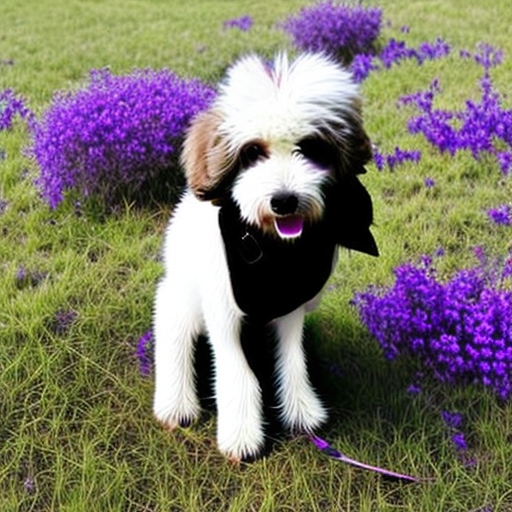

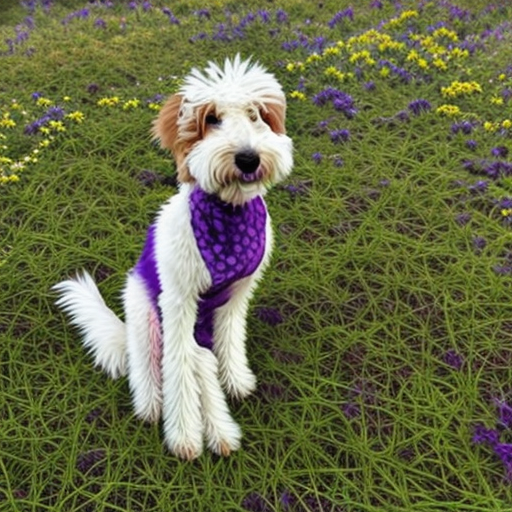

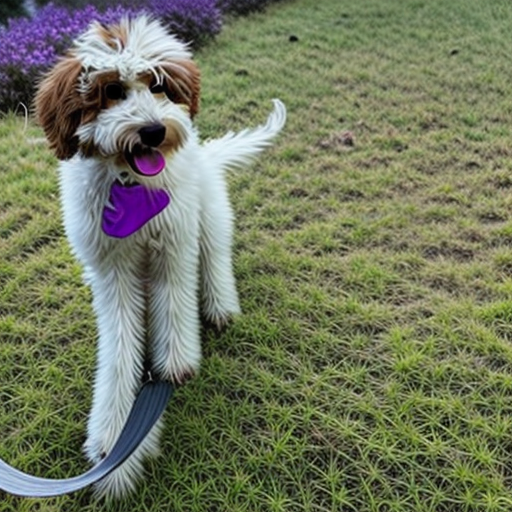

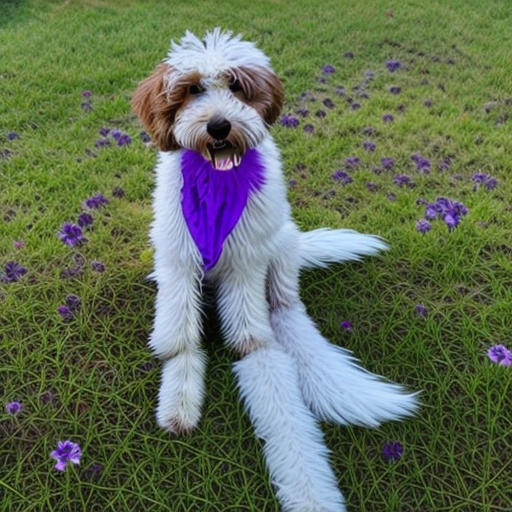

[None, None, None, None]

In [18]:
[display(image) for image in images]